# GROUP 1 - GNN and Vertex k -center problem


---

### Imports

In [1]:
import numpy as np
import math
import networkx as nx
import time

# Part 1: Traditional K-Center Computation Techniques

Before training our GNN, it is important to develop a framework for generating quality data.  This involves implementing the various algorithms for calculating the k-center.

Although we could use approximation algorithms for computing the 1-center, it is actually more efficient to develop a separate algorithm for doing this task.  In the special case of the 1-center, we can actually find a more efficient solution that minimizes the amount of effort taken to reach all of the nodes of the graph.

The algorithm below works as follows:
1) Compute the distances between all of the vertices of the graph
2) Compute the total "traveling time" it would take to reach all other vertices in one path from each vertex.  This is just a sum of all of the distances in a single column/row of the distance matrix.
3) Iterate through these 'traveling times' to find the vertices that minimize the sums and record them in a list.
4) Return that list

The algorithm returns all of the possible vertices that satisfy the minimizing conditions

#### Single center algorithm 

In [2]:
def one_center(G, weighted=False, distance=False):
    '''
    Function computes distances between all vertices of graph and iterates through edge weights to compute vertices that minimize weights.
    Resulting vertices that fit are returned as a list.
    Weighted as false reduces computational time marginally.
    '''
    distances = G.distance_matrix(by_weight=weighted)
    sums = sum(distances.columns())
    vertices = G.vertices()
    centers = []
    min_dist = sums[0]
    # iterates through each
    for vertex in range(len(sums)):
        dists = sums[vertex]
        if dists < min_dist:
            min_dist = dists
            centers = [vertex]
        elif dists == min_dist:
            centers.append(vertex)
    if distance:
        return [vertices[c] for c in centers], min_dist
    return centers

Total distance traveled if every vertex is to be visited, each time starting at the center: 660


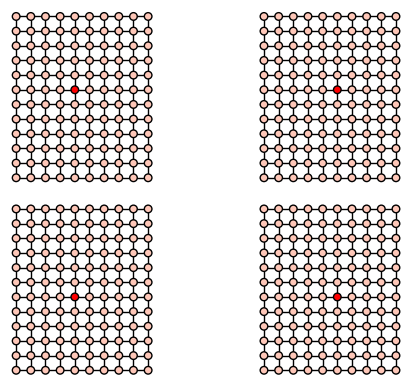

In [3]:
g = graphs.GridGraph((12, 10))

centers, distance = one_center(g, distance=True)

print("Total distance traveled if every vertex is to be visited, each time starting at the center: " + str(distance))

ga = [g.plot(vertex_colors={'red': [center]}, vertex_labels=False, vertex_size=30) for center in centers]

graphics_array(ga, nrows=int(math.sqrt(len(ga))))

Before implementing an exact solution to the k-center problem, we must create a complete graph, as the minimim dominating set algorithm will not provide accurate results otherwise.  Each edge in the complete graph caputures the distance between the two vertices it connects.

In [4]:
def convert_to_complete(G, weighted=False):
    '''
    Function that converts graph to complete graph. Edge weights are distances between the vertices. 
    Weighted as false reduced computational time.
    '''
    all_edges = []
    vertices = G.vertices()
    # distance is symmetric hence iterating one direction is enough
    for i in range(len(vertices)):
        for j in range(i + 1, len(vertices)):
            all_edges.append((vertices[i], vertices[j], G.distance(vertices[i], vertices[j], by_weight=weighted)))
    complete = Graph(all_edges)
    return complete

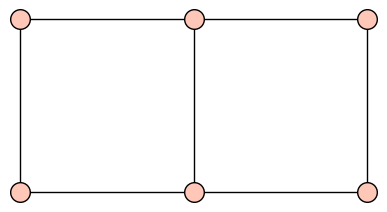

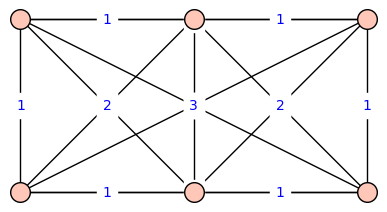

In [5]:
GG23 = graphs.GridGraph((2, 3))
GG23.show(vertex_labels=False)

convert_to_complete(GG23).show(edge_labels=True, vertex_labels=False, pos=graphs.GridGraph((2, 3)).layout())

This next function exactly solves the k-center problem effectively for 2 or more centers. This method uses the computationally complex dominating set approach to solve for the k centers. We use the minimum dominating set approach, because it is one of the main subproblems of the k-center problem.

The basic algorithm is as follows:
1) Find and sort each of the possible distances within the inputted graph into a set $D$
2) Pick a distance $d \in D$
3) Remove edges in $G$ where $distance > d$
4) Find the minimum dominating set $C_{d}$ of this new graph.
5) If $|C_{d}| > k$, repeat this process but use $d_{new} \in D$ where $d_{new} < d$

Instead of iterating through every single possible edge distance which is even more computationally expensive, we use a binary search approach to find the optimal edge weight for a k-center solution.  If this function returns a list of k-centers that has less than k elements, the most effective centering is a list of that size.  This means tht adding any other centers will improve the covering, but it is unnecessary as $\forall v \in V, distance(v, centers) \le r_{max}$ where $r_{max}$ is the optimal covering radius.  One important caveat is that the function requires that G is complete and is created by the convert_to_complete function.

#### Basic k-center Algorithm

In [6]:
def k_center(G, k=3, distance=False):
    '''
    Function takes argument graph and modifies into complete graph before implementing efficient k-center algorithm
    Detailed description of algorithm can be found above
    
    '''
    # sorted edge list by edge weight
    complete = convert_to_complete(G, weighted=True)
    weights = sorted(set([edge[2] for edge in complete.edges()]))
    high = len(weights) - 1
    low = 0
    while high - low > 1:
        mid = int(math.ceil((high + low) / 2))
        r_max = weights[mid]
        bottleneck_graph = complete.copy()
        # removes all edges from G that have a weight larger than the maximum permitted radius
        edges_to_remove = [edge for edge in complete.edges() if edge[2] > r_max]
        bottleneck_graph.delete_edges(edges_to_remove)
        centers = bottleneck_graph.dominating_set()
        # binary search within weights
        if len(centers) <= k:
            high = mid
        else:
            low = mid
    if len(centers) > k:
        mid += 1
        r_max = weights[mid]
        bottleneck_graph = complete.copy()
        edges_to_remove = [edge for edge in complete.edges() if edge[2] > r_max]
        bottleneck_graph.delete_edges(edges_to_remove)
        centers = bottleneck_graph.dominating_set()
    if distance:
        return centers, r_max
    else:
        return centers

Normally, the k-center problem is solved with an approximation algorithm.  There are multiple approximtion algorithms designed for it like the Sh algorithm, Gon algorithm, CDS algorithm; however, the greedy algorithm is simplest to implement and a quick heuristic compared to the "more exact" approximations.

The greedy algorithm is guaranteed to have an approximation factor of no more than 2x the optimal solution.  For a GNN though, it's more effective to use the exact solution, as the computation time once the model is trained is the same regardless of the initial algorithm used to generate training data.  Further, our GNN benefits, albeit most likely marginally, from an exact algorithm.  The more correct our training data, the more we can guarantee our model's efficacy.  Where this will probably make the largest impact is in larger less regular graphs that might have a difficult to approximate solution.

#### Greedy approximation Algorithm

The basic greedy approximation algorithm works as follows:
Consider a graph G = (V, E)
1) Pick an arbitrary vertex $c_1 \in V$ to place into $C$
2) Pick the point $c_2 \in V$ with the largest distance away from $c_1$ and place this into $C$
3) Continue this process until $|C| = k$.

Since we can precompute distances with the distance_matrix() method from sage, the algorithm is ${\displaystyle {\mathcal {O}}(nk)}$

In [7]:
def k_center_approximation(G, k=3, weighted=False, seed=None, distance=False):
    ''' This function uses greedy approximation to find centers.
        Returns the resulting k-centers as specified as well as the maximum distance if required.
    '''
    G.weighted(True)
    vertices = G.vertices()
    if seed != None:
        np.random.seed(seed)
    starting_index = np.random.randint(len(vertices))
    C = [starting_index]
    deltas = []
    while len(C) < k:
        maximized_distance = 0
        for v in range(len(vertices)):
            if v in C:
                continue
            dists = [float(G.distance(vertices[v], vertices[c], by_weight=weighted)) for c in C]
            min_dist = min(dists)
            if min_dist > maximized_distance:
                maximized_distance = min_dist
                best_candidate = v
        deltas.append(maximized_distance)
        C.append(best_candidate)
    if distance:
        return [vertices[c] for c in C], min(deltas)
    else:
        return [vertices[c] for c in C]

Since the approximation algorithm is approximate, it often doesn't return the purely optimal value for the k-center, as shown below.

Here, we calculate the k-centers of two identical graphs using the two different algorithms and show the maximum distance between the centers and any vertex within a graph.

Maximum distance: 4.0




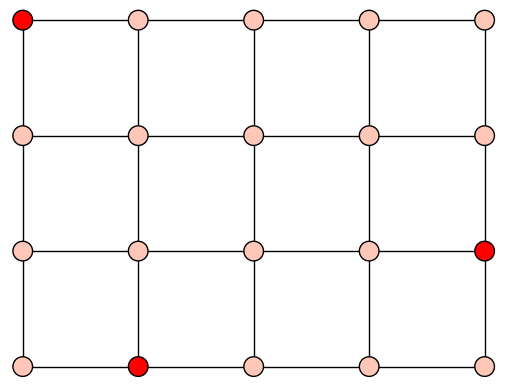

In [8]:
approx, dist = k_center_approximation(graphs.GridGraph((4, 5)), k=3, distance=True)

print("Maximum distance: " + str(dist)) ; print('\n')

graphs.GridGraph((4, 5)).plot(vertex_colors = {'red': approx}, vertex_labels=False)

Maximum distance: 2




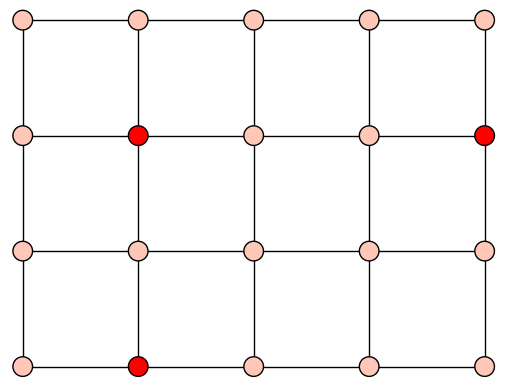

In [9]:
g = graphs.GridGraph((4, 5))
g_complete = convert_to_complete(g)

centers, dist = k_center(g_complete, k = 3, distance=True)

print("Maximum distance: " + str(dist)) ; print('\n')
g.plot(vertex_colors = {'red': centers}, vertex_labels=False)

#### Random Connected Graph creation

Algorithm for creating a random connected graph.  This will be used to train our GNN on general data.

In [10]:
def random_connected_graph(n, p, seed=None, weighted=True):
    '''
        n - number of vertices
        p - probability there is an edge between two vertices
        uses uniform distribution for edge labeling
    '''
    G = graphs.RandomGNP(n, p, seed=seed) # ensures that G is completely connected
    
    sd = seed
    while len(G.connected_components()) > 1:
        if sd != None:
            sd += 1
        G = graphs.RandomGNP(n, p, seed=sd)
    np.random.seed(seed)
    if weighted:
        for edge in G.edges():
            G.set_edge_label(edge[0], edge[1], RR(np.random.random_sample()))
    return G

Exact solution
Maximum distance to any point:0.46109750547169326




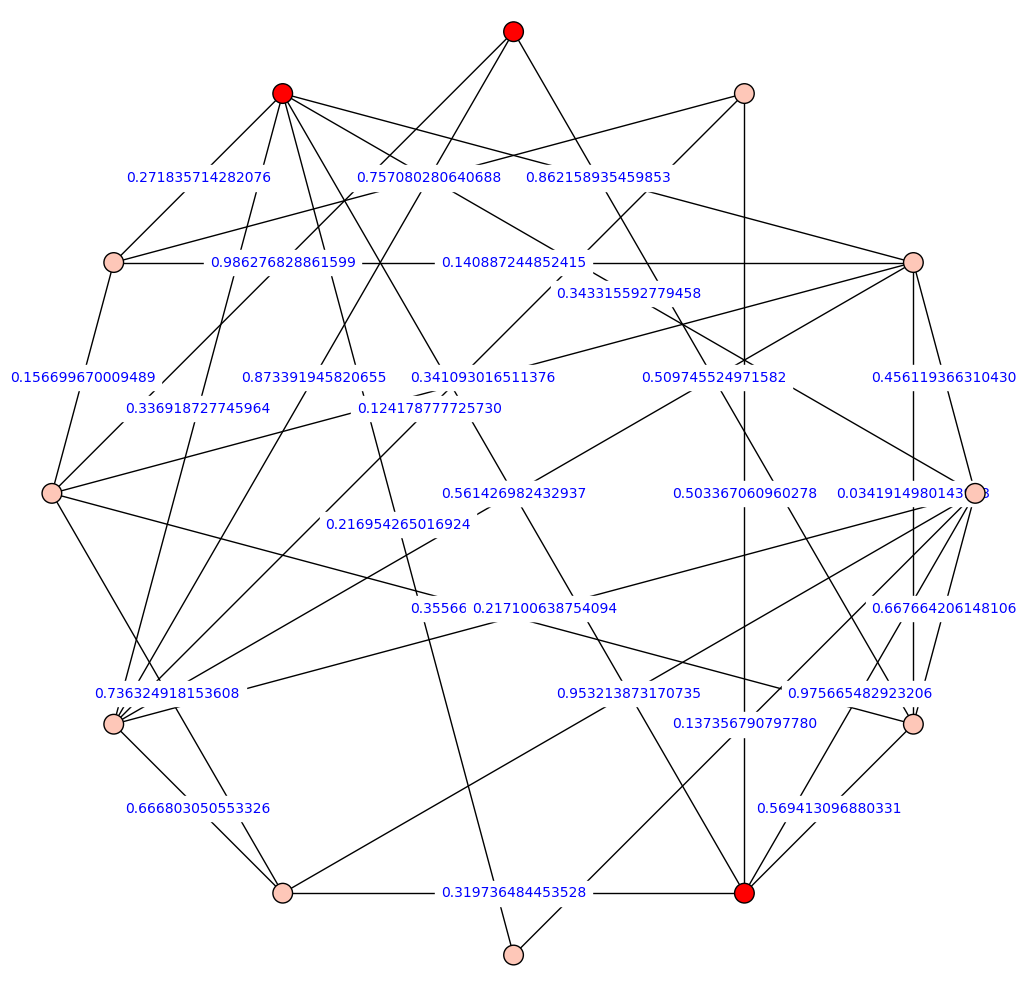

K-Center approximation
Maximum distance to any point:0.8415239378478757




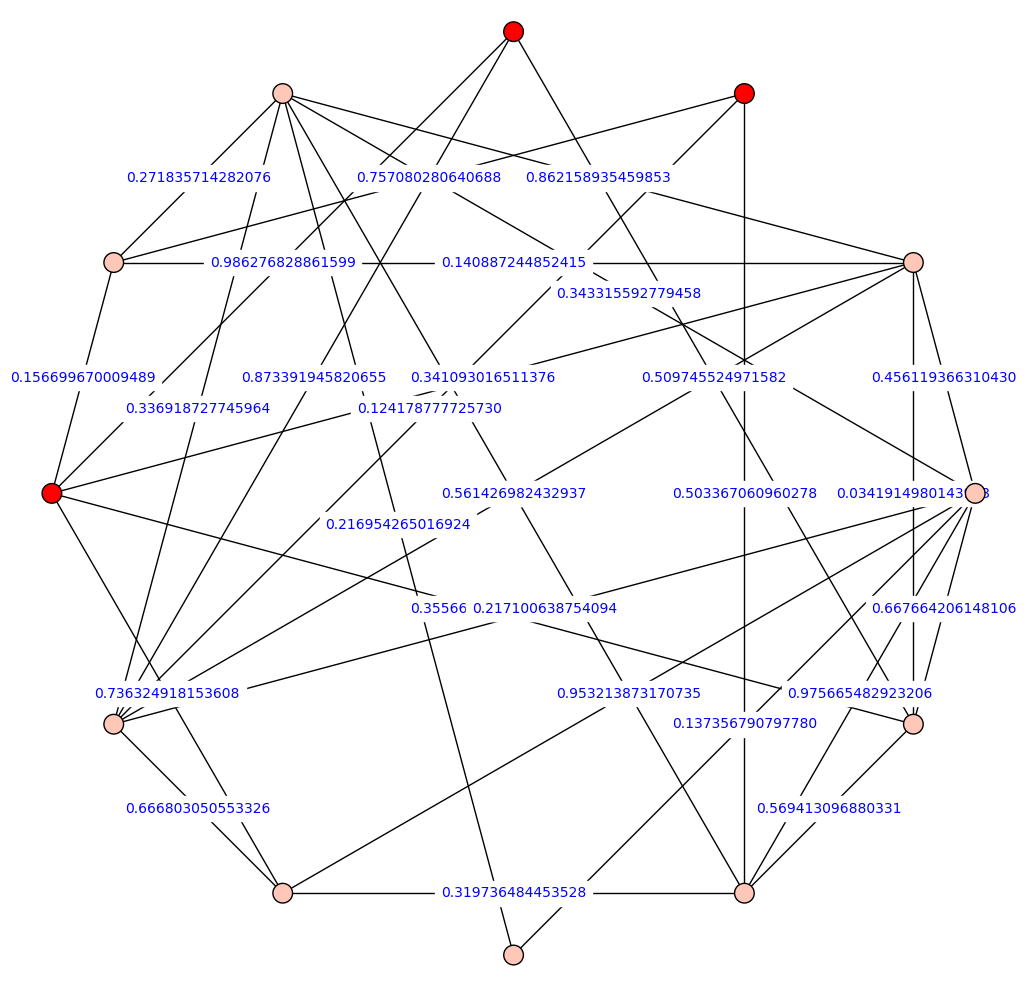

In [11]:
g = random_connected_graph(12, 0.4, seed=2020)
g.weighted(True)

centers, dist = k_center(g, k=3, distance=True)
p_exact = g.plot(layout='circular', vertex_colors={'red': centers}, vertex_labels=False, edge_labels=True)

print("Exact solution")
print('Maximum distance to any point:' + str(dist)) ; print('\n')
p_exact.show(figsize=15)

centers, dist = k_center_approximation(g, k=3, distance=True, weighted=True)
p_approximate = g.plot(layout='circular', vertex_colors={'red': centers}, vertex_labels=False, edge_labels=True)

print("K-Center approximation")
print('Maximum distance to any point:' + str(dist)) ; print('\n')
p_approximate.show(figsize=15)

# Computational cost visualization

Text(0,0.5,'runtime')

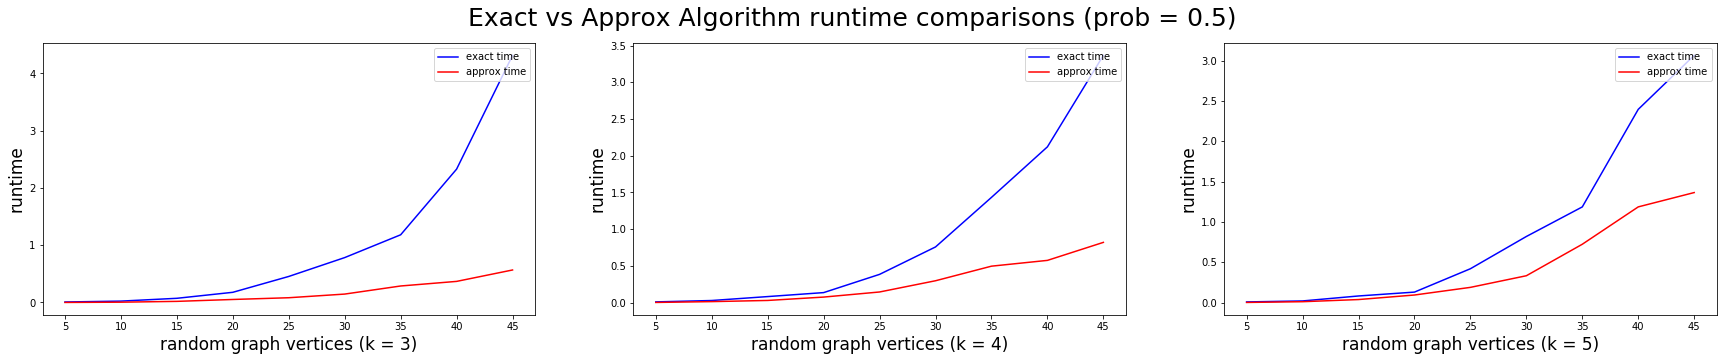

In [12]:
import matplotlib.pyplot as plt
def exact_time(G, k=3):
    t_0 = time.time()
    centers = k_center(G, k=k, distance=False)
    return time.time() - t_0
def approx_time(G, k=3):
    t_0 = time.time()
    centers = k_center_approximation(G, k=k, distance=False, weighted=True)
    return time.time() - t_0

y_vals = list(range(5,50,5))
a1 = [exact_time(random_connected_graph(i,0.5,seed = 2020)) for i in range(5,50,5)]
a1_a = [approx_time(random_connected_graph(i,0.5,seed = 2020)) for i in range(5,50,5)]
a2 = [exact_time(random_connected_graph(i,0.5,seed = 2020),k=4) for i in range(5,50,5)]
a2_a = [approx_time(random_connected_graph(i,0.5,seed = 2020),k=4) for i in range(5,50,5)]
a3 = [exact_time(random_connected_graph(i,0.5,seed = 2020),k=5) for i in range(5,50,5)]
a3_a = [approx_time(random_connected_graph(i,0.5,seed = 2020),k=5) for i in range(5,50,5)]

fig = plt.figure(figsize = (30,5))
fig.suptitle('Exact vs Approx Algorithm runtime comparisons (prob = 0.5)',fontsize = 25)

fig.add_subplot(131)
plt.plot(y_vals,a1,'b-',label = 'exact time')
plt.plot(y_vals,a1_a,'r-',label = "approx time")
plt.legend(loc = 'upper right')
plt.xlabel('random graph vertices (k = 3)',fontsize = 17)
plt.ylabel('runtime',fontsize = 17)


fig.add_subplot(132)
plt.plot(y_vals,a2,'b-',label = 'exact time')
plt.plot(y_vals,a2_a,'r-',label = "approx time")
plt.legend(loc = 'upper right')
plt.xlabel('random graph vertices (k = 4)',fontsize = 17)
plt.ylabel('runtime',fontsize = 17)

fig.add_subplot(133)
plt.plot(y_vals,a3,'b-',label = 'exact time')
plt.plot(y_vals,a3_a,'r-',label = "approx time")
plt.legend(loc = 'upper right')
plt.xlabel('random graph vertices (k = 5)',fontsize = 17)
plt.ylabel('runtime',fontsize = 17)


To try to find the clusters of data, we simply look in the neighborhoods of each center and classify vertices by their neighborhood.

In [13]:
import random
def clusters(G, centers, weighted=True, as_dict=False):
    if not as_dict:
        clusts = [0] * G.order()
        for vertex in G.vertices():
            if vertex in centers:
                continue
            closest = None
            min_dist = 100000000
            # we randomly shuffle to not skew our clustering towards the first elements of centers
            # otherwise, we get a top-heavy list of clusters which, although is correct, will make classification harder
            cs = [*range(len(centers))]
            random.shuffle(cs)
            for c in cs:
                dist = G.distance(centers[c], vertex, by_weight=weighted)
                if dist < min_dist:
                    closest = c
                    min_dist = dist
            clusts[vertex] = closest
        return clusts
    else:
        clusts = {center: [] for center in range(len(centers))}
        for vertex in G.vertices():
            if vertex in centers:
                continue
            closest = None
            min_dist = 100000000
            # we randomly shuffle to not skew our clustering towards the first elements of centers
            # otherwise, we get a top-heavy list of clusters which, although is correct, will make classification harder
            cs = [*range(len(centers))]
            random.shuffle(cs)
            for c in cs:
                dist = G.distance(centers[c], vertex, by_weight=weighted)
                if dist < min_dist:
                    closest = c
                    min_dist = dist
            clusts[closest].append(vertex)
        return clusts

g = random_connected_graph(100, 0.4, seed = 2020)
c = clusters(g, k_center_approximation(g, k = 9, distance=False), weighted=True, as_dict=True)

# Part 2: Building the GNN

As implementing a GNN efficiently from scratch is beyond our level of expertise, we will be using some functionality of the validated DGL GNN library to quicken production.

In [14]:
# GNN imports
!pip3 install --user dgl
!pip3 install --user torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import GATConv
from dgl import DGLGraph
import dgl
import networkx as nx
import time
RealNumber = float; Integer = int

You should consider upgrading via the 'pip install --upgrade pip' command.


You should consider upgrading via the 'pip install --upgrade pip' command.


Using backend: pytorch


To be able to train our network, we need to be able to format the graphs for the DGL library.  This first involves converting it to a networkx graph, passing those values into a child class of networkx called DGLGraph, and computing the required information about each individual graph (where the centers are, what are the clusters, what labels are associated with the centers, etc.).  This is made somewhat time inefficient because we are using sage, but it's quick enough to where it's not very noticable.

In [15]:
def convert_to_DGLGraph(G, k=3, weighted=True):
    if weighted:
        nxgraph = G.networkx_graph(weight_function = lambda edge: float(edge[2]))
    else:
        nxgraph = G.networkx_graph(weight_function = lambda edge: float(1))
    dgl_G = dgl.DGLGraph()
    dgl_G.from_networkx(nxgraph, edge_attrs=['weight'])
    centers, distance = k_center_approximation(G, k=k, distance=True)
    centers = [int(c) for c in centers]
    labels = torch.LongTensor([int(1) if node in centers else int(0) for node in G.vertices()])
    mask = torch.BoolTensor([True for _ in range(len(labels))])
    clusts = clusters(G, centers, weighted=weighted)
    return dgl_G, centers, labels, mask, clusts
convert_to_DGLGraph(random_connected_graph(12, 0.4, seed=2020))

(DGLGraph(num_nodes=12, num_edges=52,
          ndata_schemes={}
          edata_schemes={'weight': Scheme(shape=(), dtype=torch.float32)}),
 [7, 0, 5],
 tensor([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]),
 tensor([True, True, True, True, True, True, True, True, True, True, True, True]),
 [0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 1, 0])

The GAT layer is the backbone of our graph attention network and is based on four key equations.

Equation 1 is a linear transformation, implemented with the nn.Linear function from pytorch.

Equation 2 calculates the un-normalized attention score $e_{ij}$ using the learned embeddings of adjacent nodes $i$ and $j$.

Equation 3 normalizes the attention scores using softmax

Equation 4 performs a one-step aggregation of each node's neighbor embeddings using the learned attention as weights.

\begin{split}\begin{align}
z_i^{(l)}&=W^{(l)}h_i^{(l)},&(1) \\
e_{ij}^{(l)}&=\text{LeakyReLU}(\vec a^{(l)^T}(z_i^{(l)}||z_j^{(l)})),&(2)\\
\alpha_{ij}^{(l)}&=\frac{\exp(e_{ij}^{(l)})}{\sum_{k\in \mathcal{N}(i)}^{}\exp(e_{ik}^{(l)})},&(3)\\
h_i^{(l+1)}&=\sigma\left(\sum_{j\in \mathcal{N}(i)} {\alpha^{(l)}_{ij} z^{(l)}_j }\right),&(4)
\end{align}\end{split}

In [17]:
class GATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim):
        super(GATLayer, self).__init__()
        self.g = g
        # equation (1)
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        # equation (2)
        self.attn_fc = nn.Linear(2 * out_dim, 1, bias=False)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.fc.weight, gain=gain)
        nn.init.xavier_normal_(self.attn_fc.weight, gain=gain)

    def edge_attention(self, edges):
        # edge UDF for equation (2)
        z2 = torch.cat([edges.src['z'], edges.dst['z']], dim=1)
        a = self.attn_fc(z2)
        return {'e': F.leaky_relu(a)}

    def message_func(self, edges):
        # message UDF for equation (3) & (4)
        return {'z': edges.src['z'], 'e': edges.data['e']}

    def reduce_func(self, nodes):
        # reduce UDF for equation (3) & (4)
        # equation (3)
        alpha = F.softmax(nodes.mailbox['e'], dim=1)
        # equation (4)
        h = torch.sum(alpha * nodes.mailbox['z'], dim=1)
        return {'h': h}

    def forward(self, h):
        # equation (1)
        z = self.fc(h)
        self.g.ndata['z'] = z
        # equation (2)
        self.g.apply_edges(self.edge_attention)
        # equation (3) & (4)
        self.g.update_all(self.message_func, self.reduce_func)
        return self.g.ndata.pop('h')

Our GAT uses multiple layers for more accurate classification.  Each attention head has its own parameters and uses the following two equations to merge the information.  Concatenation is used in the middle layers and the average is used in the final layer.
\begin{align}\text{concatenation}: h^{(l+1)}_{i} =||_{k=1}^{K}\sigma\left(\sum_{j\in \mathcal{N}(i)}\alpha_{ij}^{k}W^{k}h^{(l)}_{j}\right)\end{align}

and

\begin{align}\text{average}: h_{i}^{(l+1)}=\sigma\left(\frac{1}{K}\sum_{k=1}^{K}\sum_{j\in\mathcal{N}(i)}\alpha_{ij}^{k}W^{k}h^{(l)}_{j}\right)\end{align}

In [18]:
class MultiHeadGATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim, num_heads, merge='cat'):
        super(MultiHeadGATLayer, self).__init__()
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(GATLayer(g, in_dim, out_dim))
        self.merge = merge

    def forward(self, h):
        head_outs = [attn_head(h) for attn_head in self.heads]
        if self.merge == 'cat':
            # concat on the output feature dimension (dim=1)
            return torch.cat(head_outs, dim=1)
        else:
            # merge using average
            return torch.mean(torch.stack(head_outs))

This combines all of the structure from the previous two code cells into one GAT class that we can easily call and create our GNN with.

In [19]:
class GAT(nn.Module):
    def __init__(self, g, in_dim, hidden_dim, out_dim, num_heads):
        super(GAT, self).__init__()
        self.layer1 = MultiHeadGATLayer(g, in_dim, hidden_dim, num_heads)
        # Be aware that the input dimension is hidden_dim*num_heads since
        # multiple head outputs are concatenated together. Also, only
        # one attention head in the output layer.
        self.layer2 = MultiHeadGATLayer(g, hidden_dim * num_heads, out_dim, 1)

    def forward(self, h):
        h = self.layer1(h)
        h = F.elu(h)
        h = self.layer2(h)
        return h

Before implementing a GNN, we must first convert our graph into a format suitable for a Neural Network.  Typically, GNNs and various other neural networks use real data with structure-independent features.  Since the graphs we are using are purely abstract and have no attributes associated to the nodes, we will approach feature generation differently.  Instead, we will artificially construct features for each node that describe its connectivity in an abstract form. 

For any arbitrary graph, we want to create an order isomorphic way of describing how far away nodes are within a graph.  Since the direct mapping to a feature vector for node i where $\overrightarrow{h_i} = \begin{bmatrix} dist(i, 1) \\ dist(i, 2) \\. \\ . \\dist(i, n) \end{bmatrix}$ only works for identically labeled graphs, we instead denote a feature vector as follows:

Consider an arbitrary connected n-node graph $G$.

The k-dimensional feature vector (k is an arbitrary dimension somewhat analogous to desired accuracy) is $\overrightarrow{h_i} = \begin{bmatrix} h_{i, 1} \\ h_{i, 2} \\. \\ . \\ h_{i, k} \end{bmatrix} \in \RR^k$ where $h_{i, j} = |\{dist(i, j) |  dist(i, j)$ is in the $j^{th}$ equal interval of $[0, Diameter(G)]\}|$

In [20]:
def extract_features(G, dim=10, weighted=True):
    features = np.zeros((G.order(), dim))
    resolution = float(G.diameter(by_weight=weighted)) / dim
    vertices = G.vertices()
    for i in range(len(vertices)):
        for j in range(i + 1, len(vertices)):
            distance = G.distance(vertices[i], vertices[j], by_weight=weighted)
            section = min(int(math.floor(distance/resolution)), dim - 1)
            features[i, section] += 1
            features[j, section] += 1
    return torch.FloatTensor(features)
extract_features(graphs.GridGraph((3, 4)), dim = 5, weighted=False)

tensor([[0., 2., 3., 3., 3.],
        [0., 3., 4., 3., 1.],
        [0., 3., 4., 3., 1.],
        [0., 2., 3., 3., 3.],
        [0., 3., 3., 3., 2.],
        [0., 4., 5., 2., 0.],
        [0., 4., 5., 2., 0.],
        [0., 3., 3., 3., 2.],
        [0., 2., 3., 3., 3.],
        [0., 3., 4., 3., 1.],
        [0., 3., 4., 3., 1.],
        [0., 2., 3., 3., 3.]])

#### Training our GNN on node clustering

In the following cell, we start by having our GNN classify the graph into two clusters.  Although this is a small subset of the k-center problems, it is the best candidate to visualize as the output is only two dimensional.  We train this network on 30 random connected graphs of order 50, iterating through each graph only once to save time.  On my (Elia's) system, this took about 2 minutes.  To decrease computation time, you can decrease the amount of graphs to train on.

In [21]:
weighted = True
# creating the graphs to train on
G = [random_connected_graph(50, 0.4, weighted=True) for _ in range(30)]
# initializing graph features with 'resolution' 30
features = [extract_features(graph, dim=30, weighted=True) for graph in G]

In [22]:
k = 2
# GNN Creation and training
g = []
centers = []
labels = []
masks = []
clusts = []
for graph in G:
    dgl_graph, c, l, m, clsts = convert_to_DGLGraph(graph, k=k, weighted=weighted)
    g.append(dgl_graph)
    centers.append(c)
    labels.append(l)
    masks.append(m)
    clusts.append(torch.LongTensor(clsts))

# creating the network
net_2_clustering = GAT(g[0],
      in_dim=features[0].size()[1],
      hidden_dim=k*2,
      out_dim=2,
      num_heads=5)

optimizer = torch.optim.Adam(net_2_clustering.parameters(), lr=1e-3)

duration = []
losses = []
count = 0
for k in range(1):
    for i in range(len(g)):
        for epoch in range(25):
            count += 1
            if epoch >= 3:
                t0 = time.time()

            logits = net_2_clustering(features[i])
            logp = F.log_softmax(logits, 1)
            loss = F.nll_loss(logp, clusts[i])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch >= 3:
                duration.append(time.time() - t0)
                losses.append(loss.item())
            # print("Epoch {:05d} | Loss {:.4f} | Time(s) {:.4f}".format(
            #    count, loss.item(), np.mean(duration)))


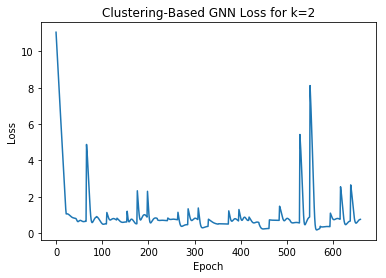

In [23]:
plt.plot([*range(len(losses))], losses)
plt.title("Clustering-Based GNN Loss for k=2")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Text(0.5,1,'Visualization of Clustering-GNN output for k=2')

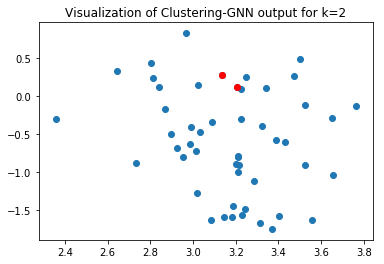

In [24]:
test_graph = random_connected_graph(50, 0.4, weighted=True)
test_features = extract_features(test_graph, dim=30, weighted=True)
test_centers = k_center_approximation(test_graph, k=2, distance=False)
test_clusters = clusters(test_graph, test_centers, weighted=True, as_dict=True)
results = net_2_clustering(test_features).detach().numpy()
plt.scatter(results[:, 0], results[:, 1])
plt.scatter(results[test_centers, 0], results[test_centers, 1], c='red')
plt.title("Visualization of Clustering-GNN output for k=2")

We can generalize this approach to however many clusters/k-centers we want.  In this case, we try training our network on 6 centers/clusters (This is so that there are enough colors to display the clusters in the visualizations; aside from that the choice of k is arbitrary as long as its larger than 2).  Although the same algorithm/approach applies, this network now returns an 6-dimensional vector which is much more difficult to visualize.  We try to combat this through two dimension reduction techniques: TSNE (T-distributed Stochastic Neighbor Embedding) and PCA (Principle Component Analysis)

In [25]:
k = 6

g = []
centers = []
labels = []
masks = []
clusts = []
for graph in G:
    dgl_graph, c, l, m, clsts = convert_to_DGLGraph(graph, k=k, weighted=weighted)
    g.append(dgl_graph)
    centers.append(c)
    labels.append(l)
    masks.append(m)
    clusts.append(torch.LongTensor(clsts))

# creating the network
net_6_clustering = GAT(g[0],
      in_dim=features[0].size()[1],
      hidden_dim=k*2,
      out_dim=k,
      num_heads=5)

optimizer = torch.optim.Adam(net_6_clustering.parameters(), lr=1e-3)

duration = []
losses = []
count = 0
for k in range(1):
    for i in range(len(g)):
        for epoch in range(25):
            count += 1
            if epoch >= 3:
                t0 = time.time()

            logits = net_6_clustering(features[i])
            logp = F.log_softmax(logits, 1)
            loss = F.nll_loss(logp, clusts[i])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch >= 3:
                duration.append(time.time() - t0)
                losses.append(loss.item())
            # print("Epoch {:05d} | Loss {:.4f} | Time(s) {:.4f}".format(
            #    count, loss.item(), np.mean(duration)))


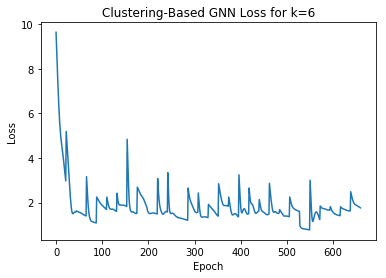

In [26]:
plt.plot([*range(len(losses))], losses)
plt.title("Clustering-Based GNN Loss for k=6")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [27]:
test_graph = random_connected_graph(50, 0.4, weighted=True)
test_features = extract_features(test_graph, dim=30, weighted=True)
test_centers = k_center_approximation(test_graph, k=6, distance=False)
test_clusters = clusters(test_graph, test_centers, weighted=True, as_dict=True)
results = net_6_clustering(test_features).detach().numpy()

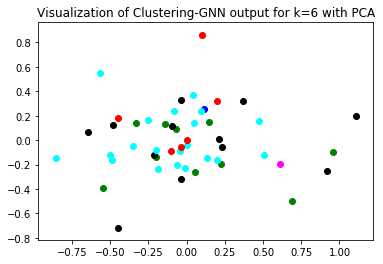

Explained variation per principal component: [0.4494156  0.19313718]


In [28]:
from sklearn.decomposition import PCA
colors = ['blue', 'green', 'black', 'cyan', 'magenta', 'yellow', 'red']
pca = PCA(n_components=2)
pca_result = pca.fit_transform(results)
dim1 = pca_result[:,0]
dim2 = pca_result[:,1]
# plt.scatter(dim1, dim2)
# For some reason plotting in a for loop doesn't work, so we just repeat the code for each cluster
plt.scatter(dim1[test_clusters[0]], dim2[test_clusters[0]], c=colors[0])
plt.scatter(dim1[test_clusters[1]], dim2[test_clusters[1]], c=colors[1])
plt.scatter(dim1[test_clusters[2]], dim2[test_clusters[2]], c=colors[2])
plt.scatter(dim1[test_clusters[3]], dim2[test_clusters[3]], c=colors[3])
plt.scatter(dim1[test_clusters[4]], dim2[test_clusters[4]], c=colors[4])
plt.scatter(dim1[test_clusters[5]], dim2[test_clusters[5]], c=colors[5])
plt.scatter(dim1[test_centers], dim2[test_centers], c='red')
plt.title("Visualization of Clustering-GNN output for k=6 with PCA")
plt.show()
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 50 samples in 0.000s...
[t-SNE] Computed neighbors for 50 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 50 / 50
[t-SNE] Mean sigma: 0.295878
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.484360
[t-SNE] KL divergence after 300 iterations: 1.498362
t-SNE done! Time elapsed: 0.19801807403564453 seconds


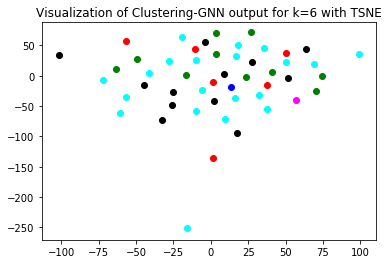

In [29]:
from sklearn.manifold import TSNE
t0 = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=15, n_iter=300)
tsne_results = tsne.fit_transform(results)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-t0))
dim1 = tsne_results[:, 0]
dim2 = tsne_results[:, 1]
# plt.scatter(dim1, dim2)
plt.scatter(dim1[test_clusters[0]], dim2[test_clusters[0]], c=colors[0])
plt.scatter(dim1[test_clusters[1]], dim2[test_clusters[1]], c=colors[1])
plt.scatter(dim1[test_clusters[2]], dim2[test_clusters[2]], c=colors[2])
plt.scatter(dim1[test_clusters[3]], dim2[test_clusters[3]], c=colors[3])
plt.scatter(dim1[test_clusters[4]], dim2[test_clusters[4]], c=colors[4])
plt.scatter(dim1[test_clusters[5]], dim2[test_clusters[5]], c=colors[5])
plt.scatter(dim1[test_centers], dim2[test_centers], c='red')
plt.title("Visualization of Clustering-GNN output for k=6 with TSNE")
plt.show()

#### Training our network on centers

Here, we approach the k-center problem from the original angle.  We train our network to classify vertices depending on whether or not they are centers.  The algorithm itself is virtually unchanged.  This, unfortunately, relies on relatively sparse data, as the vertices often outnumber the amount of centers in realistic applications.  Still, we can try to extract valuable information from this approach, mainly stemming from the 2-dimensional output.

In [30]:
k = 10

g = []
centers = []
labels = []
masks = []
clusts = []
for graph in G:
    dgl_graph, c, l, m, clsts = convert_to_DGLGraph(graph, k=k, weighted=weighted)
    g.append(dgl_graph)
    centers.append(c)
    labels.append(l)
    masks.append(m)
    clusts.append(torch.LongTensor(clsts))

# creating the network
net_centers = GAT(g[0],
      in_dim=features[0].size()[1],
      hidden_dim=10,
      out_dim=2,
      num_heads=2)

optimizer = torch.optim.Adam(net_centers.parameters(), lr=1e-3)

duration = []
losses = []
count = 0
for k in range(1):
    for i in range(len(g)):
        for epoch in range(25):
            count += 1
            if epoch >= 3:
                t0 = time.time()

            logits = net_centers(features[i])
            logp = F.log_softmax(logits, 1)
            loss = F.nll_loss(logp, labels[i])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch >= 3:
                duration.append(time.time() - t0)
                losses.append(loss.item())

            # print("Epoch {:05d} | Loss {:.4f} | Time(s) {:.4f}".format(
            #    count, loss.item(), np.mean(duration)))


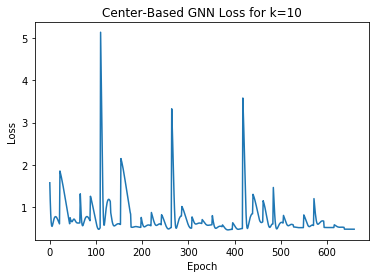

In [31]:
plt.plot([*range(len(losses))], losses)
plt.title("Center-Based GNN Loss for k=10")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

[40, 0, 4, 14, 28, 35, 46, 1, 2, 3]


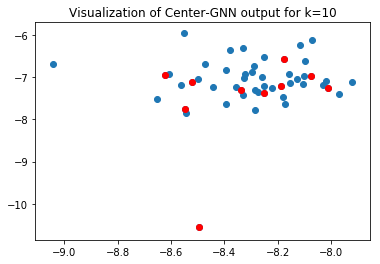

In [32]:
test_graph = random_connected_graph(50, 0.4, weighted=True)
test_features = extract_features(test_graph, dim=30, weighted=True)
test_centers = k_center_approximation(test_graph, k=10, distance=False)
print(test_centers)
results = net_centers(test_features).detach().numpy()
plt.scatter(results[:, 0], results[:, 1])
plt.scatter(results[test_centers, 0], results[test_centers, 1], c='red')
plt.title("Visualization of Center-GNN output for k=10")
plt.show()

#### Instance of GNN with features clearly defined 

To see how effective this approach is on real world data compared to our problem, we implemented one of the original paper's GNN's for the cora citation dataset.

In [33]:
from dgl import DGLGraph
from dgl.data import citation_graph as citegrh
import networkx as nx

def load_cora_data():
    data = citegrh.load_cora()
    features = torch.FloatTensor(data.features)
    labels = torch.LongTensor(data.labels)
    mask = torch.BoolTensor(data.train_mask)
    g = DGLGraph(data.graph)
    # torch.set_printoptions(threshold=5000)
    return g, features, labels, mask

In [34]:
g, features, labels, mask = load_cora_data()
data = citegrh.load_cora()

# create the model, 2 heads, each head has hidden size 8
net = GAT(g,
          in_dim=features.size()[1],
          hidden_dim=8,
          out_dim=7,
          num_heads=2)

# create optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
print(labels)
# main loop
dur = []
for epoch in range(30):
    if epoch >= 3:
        t0 = time.time()

    logits = net(features)
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[mask], labels[mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >= 3:
        dur.append(time.time() - t0)

    print("Epoch {:05d} | Loss {:.4f} | Time(s) {:.4f}".format(
        epoch, loss.item(), np.mean(dur)))

tensor([2, 5, 4,  ..., 1, 0, 2])
Epoch 00000 | Loss 1.9505 | Time(s) nan


/ext/sage/sage-9.0/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/ext/sage/sage-9.0/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 00001 | Loss 1.9481 | Time(s) nan
Epoch 00002 | Loss 1.9458 | Time(s) nan


Epoch 00003 | Loss 1.9435 | Time(s) 0.1454
Epoch 00004 | Loss 1.9411 | Time(s) 0.1499


Epoch 00005 | Loss 1.9388 | Time(s) 0.1569
Epoch 00006 | Loss 1.9365 | Time(s) 0.1609


Epoch 00007 | Loss 1.9342 | Time(s) 0.1699
Epoch 00008 | Loss 1.9318 | Time(s) 0.1706


Epoch 00009 | Loss 1.9295 | Time(s) 0.1734
Epoch 00010 | Loss 1.9272 | Time(s) 0.1723


Epoch 00011 | Loss 1.9248 | Time(s) 0.1723
Epoch 00012 | Loss 1.9225 | Time(s) 0.1699


Epoch 00013 | Loss 1.9202 | Time(s) 0.1671
Epoch 00014 | Loss 1.9178 | Time(s) 0.1638


Epoch 00015 | Loss 1.9154 | Time(s) 0.1605
Epoch 00016 | Loss 1.9131 | Time(s) 0.1573


Epoch 00017 | Loss 1.9107 | Time(s) 0.1544
Epoch 00018 | Loss 1.9083 | Time(s) 0.1517


Epoch 00019 | Loss 1.9059 | Time(s) 0.1499
Epoch 00020 | Loss 1.9035 | Time(s) 0.1486


Epoch 00021 | Loss 1.9011 | Time(s) 0.1479
Epoch 00022 | Loss 1.8987 | Time(s) 0.1466


Epoch 00023 | Loss 1.8962 | Time(s) 0.1456
Epoch 00024 | Loss 1.8938 | Time(s) 0.1463


Epoch 00025 | Loss 1.8913 | Time(s) 0.1486
Epoch 00026 | Loss 1.8888 | Time(s) 0.1487


Epoch 00027 | Loss 1.8864 | Time(s) 0.1490


Epoch 00028 | Loss 1.8839 | Time(s) 0.1520
Epoch 00029 | Loss 1.8813 | Time(s) 0.1528


##### This is a visualization of the attention learned for each edge on the CORA dataset
![](https://data.dgl.ai/tutorial/gat/cora-attention.png)